# Logistic Regression with Julia

This is an exercise to adopt Julia in simple machine learning. This project is adapted from "Neural Networks and Deep Learning" by Andrew Ng of deeplearning.ai. The original implementation is on Python, and this project seeks to replicate the project using Julia programming.

## Import relevant packages

In [ ]:
# Run this cell only if you do not have HDF5 and PyPlot installed
using Pkg
Pkg.add("HDF5")
Pkg.add("PyPlot")

In [1]:
using HDF5 # to read the .h5 dataset
using Plots # to plot line chart
using PyPlot # to visualize the images
using Random # Random numbers generator
using Statistics # to calculate summary statistics
using BenchmarkTools

## Load Data

In [2]:
function load_data(filename, set_name)
    # Extract input features (the images)
    set_x = h5read("$filename","$(set_name)_x")
    set_x = permutedims(set_x,(4,3,2,1)) # Need to re-order the matrix for it to be readable
    println("Shape of $(set_name)_x: $(size(set_x)).")
    
    set_y = h5read("$filename","$(set_name)_y")
    set_y = reshape(set_y, (1,size(set_y)[1])) # reshape the output labels to fit the model better
    println("Shape of $(set_name)_y: $(size(set_y)).")
    
    set_class = h5read("$filename","list_classes") # extract class information
    println(set_class)
    return set_x, set_y, set_class
end

load_data (generic function with 1 method)

In [3]:
train_file = "train_catvnoncat.h5"
trainset_x, trainset_y, trainset_class = load_data(train_file, "train_set");

Shape of train_set_x: (209, 64, 64, 3).
Shape of train_set_y: (1, 209).
["non-cat", "cat"]


In [4]:
test_file = "test_catvnoncat.h5"
testset_x, testset_y, testset_class = load_data(test_file, "test_set");

Shape of test_set_x: (50, 64, 64, 3).
Shape of test_set_y: (1, 50).
["non-cat", "cat"]


## Visualize the images

In order to understand our dataset better, sometimes it is useful to visualize our dataset. Here, we will use the PyPlot package.

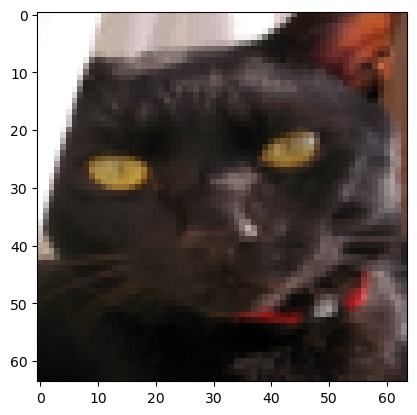

Image 84 of the train set shows a 'cat' picture!


In [5]:
index = rand(1:209)
println("Image $index of the train set shows a '$(trainset_class[trainset_y[index]+1])' picture!")
imshow(trainset_x[index,:,:,:]);

## Data processing

Here we shall work on processing the matrices such that they could fit into the model. Also, we shall create variables such as ```m_train``` and ```m_test``` to store the number of train and test data we have.

In [6]:
m_train = size(trainset_x)[1]
m_test = size(testset_x)[1]

println("Our train set has a total of $m_train samples, and our test set has $m_test samples.")

Our train set has a total of 209 samples, and our test set has 50 samples.


In [7]:
# Flattening the input features into an one-dimensional array
trainset_x_flattened = Int.(transpose(reshape(trainset_x, (m_train,:))))
testset_x_flattened = Int.(transpose(reshape(testset_x, (m_test,:))))

println("The dimension of the trainset is $(size(trainset_x_flattened)).")
println("The dimension of the testset is $(size(testset_x_flattened)).")


The dimension of the trainset is (12288, 209).
The dimension of the testset is (12288, 50).


In [8]:
# Scale data
trainset_x_final = trainset_x_flattened ./ 255
testset_x_final = testset_x_flattened ./ 255;

## Building our algorithm

Mathematical expression of the logistic regression algorithm:<br>
For an example $x^{(i)}$:<br>
$z^{(i)} = w^Tx^{(i)}+b$<br>
$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$<br>
$\mathcal{L}(a^{(i)},y^{(i)}) = -y^{(i)}log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$<br>

The cost of summing over all training examples: $J = \frac{1}{m} \sum^m_{i=1} \mathcal{L}(a^{(i)},y^{(i)})$

Steps to building the model:
1. Define Sigmoid function, to be used by the Gradient Descent Algorithm
2. Build the Gradient Descent Algorithm, which comes in 3 parts:
    - Forward and Backward propagation
    - Initialize weights (w) and bias (b)
    - Optimization - the constant update of weights and bias with given number of iterations and learning rate
3. Create the Predict Function, which would predict the label given the input features, using the trained weights and bias

### Define the Sigmoid function

In [9]:
Sigmoid(z) = 1/(1+exp(-z));

In [10]:
# Test the sigmoid function
Sigmoid.([2 0])

1×2 Array{Float64,2}:
 0.880797  0.5

From this trial, we can safely assume that our function is created properly and is good to go!<br>
Also to note - the broadcasting method used "Sigmoid.(array)".

### Gradient Descent Algorithm

#### Initialize weights and bias

In [11]:
function initialize_with_zeroes(dim)
    # Initialize vector W with given dimension
    W = zeros(Float64, dim, 1)
    b = 0.
    
    return W, b
end

initialize_with_zeroes (generic function with 1 method)

In [12]:
# Test function
W, b = initialize_with_zeroes(2)
println("W = $W, dimension = $(size(W))")
println("b = $b")

W = [0.0; 0.0], dimension = (2, 1)
b = 0.0


### Forward and Backward Propagation
Forward Propagation:
- get X
- Compute $A = \sigma(w^TX+b) = (a^{(1)}, a^{(2)}, ..., a^{(m)}$)
- Calculate Cost Function $J = -\frac{1}{m}\sum_i^m (y^{(i)}log(a^{(i)})+(1-y)log(1-a^{(i)}))$

Backward Propagation:
- $\frac{dJ}{dw} = dw = \frac{1}{m}X(A-Y)^T$
- $\frac{dJ}{dvb} = db = \frac{1}{m}\sum_{i = 1}^m(a^{(i)}-y^{(i)})$


In [13]:
function propagate(w, b, X, Y)
    m = size(X)[2]
    
    # Forward Propagation
    A = Sigmoid.(transpose(w)*X .+ b)
    J = -1/m * sum(Y*transpose(log.(A)) .+ (1 .- Y) * transpose(log.( 1 .- A)))
    
    # Backward Propagation
    dw = 1/m .* X*transpose(A-Y)
    db = 1/m * sum(A-Y)
    
    return dw, db, J
end

propagate (generic function with 1 method)

In [14]:
# Test function
w, b, X, Y = reshape([1.; 2.],(2,1)), 2., [1. 2. -1.;3. 4. -3.2], [1 0 1]
dw, db, cost = propagate(w, b, X, Y)
println("dw = $dw")
println("db = $db")
println("cost = $cost")

dw = [0.998456014637956; 2.3950723884862066]
db = 0.001455578136784208
cost = 5.801545319394553


The trickiest part of writing this code applying Linear Algebra is that one has to be very conscious of the broadcasting rule. To broadcast a function, one needs to add a period "." after the function name (e.g. "Sigmoid.()", "log.()") or before the operators (".-").<br>

Also, some operations are already matrix operations (example "sum()"), which does not require broadcasting. Also, to apply dot product, one may simply use "*".

#### Optimization

In [28]:
function optimize(w, b, X, Y, num_iter, learning_rate; print_cost = false)
    costs = zeros(0)
    for i in 1:num_iter
        
        dw, db, cost = propagate(w, b, X, Y)
        
        w -= learning_rate*dw
        b -= learning_rate*db
        
        if i%100 == 0
            append!(costs, cost)
            if print_cost == true
                println("Cost after iteration $i: $cost") 
            end
        end
    end
        
    return w, b, dw, db, costs
end

optimize (generic function with 2 methods)

In [16]:
# Test Function
w, b, dw, db, costs = optimize(w, b, X, Y, 100, 0.009)
println("w = $w")
println("b = $b")
println("dw = $dw")
println("db = $db")

Cost after iteration 100: 1.0784313398164707
w = [0.19033590888604338; 0.12259159246561407]
b = 1.9253598300845747
dw = [0.998456014637956; 2.3950723884862066]
db = 0.001455578136784208


#### Predict

In [17]:
function predict(w, b, X)
    m = size(X)[1]
    w = reshape(w, (m,1))
    
    A = Sigmoid.(transpose(w)*X .+ b)
    Y_pred = round.(Int,A)
    
    return Y_pred
end

predict (generic function with 1 method)

In [18]:
# Test Function
w = [0.1124579; 0.23106775]
b = -0.3
X = [1. -1.1 -3.2;1.2 2. 0.1]
println("predictions = $(predict(w, b, X))")

predictions = [1 1 0]


## Completing the Logistic Regression Model

In [36]:
function logistic_regression_model(X_train, Y_train, X_test, Y_test, num_iter = 2000, learning_rate = 0.005; print_output = true)
    
    # initialise parameters
    
    W, b = initialize_with_zeroes(size(X_train)[1])
    
    # Gradient Descent
    W, b, dw, db, costs = optimize(W, b, X_train, Y_train, num_iter, learning_rate, print_cost = print_output)
    
    # Prediction
    Y_pred_train = predict(W, b, X_train)
    Y_pred_test = predict(W, b, X_test)
    
    # Results
    train_acc = 1 - mean(abs.(Y_pred_train-Y_train))
    test_acc = 1 - mean(abs.(Y_pred_test - Y_test))
    if print_output == true
        println("Train accuracy: $(100 * train_acc)%.")
        println("Test accuracy: $(100 * test_acc)%.")
    end
    
    results = Dict("Cost" => costs, "Y_prediction_train" => Y_pred_train, "Y_prediction_test" => Y_pred_test,
                    "W" => W, "b" => b, "learning_rate" => learning_rate, "number_of_iterations" => num_iter)
    
    return results
end

logistic_regression_model (generic function with 3 methods)

In [37]:
d = logistic_regression_model(trainset_x_final, trainset_y, testset_x_final, testset_y);

Cost after iteration 100: 0.6448978829531701
Cost after iteration 200: 0.4848936141484849
Cost after iteration 300: 0.37776149521638064
Cost after iteration 400: 0.33177540555235874
Cost after iteration 500: 0.3035286720260554
Cost after iteration 600: 0.28009427757967503
Cost after iteration 700: 0.2602258475628189
Cost after iteration 800: 0.24310018399838854
Cost after iteration 900: 0.22814432769465368
Cost after iteration 1000: 0.21494377069682488
Cost after iteration 1100: 0.20318928219104626
Cost after iteration 1200: 0.19264428020365887
Cost after iteration 1300: 0.18312389153132902
Cost after iteration 1400: 0.1744810138688702
Cost after iteration 1500: 0.16659675354042908
Cost after iteration 1600: 0.15937369509858537
Cost after iteration 1700: 0.15273105849939203
Cost after iteration 1800: 0.1466011462989889
Cost after iteration 1900: 0.14092669166965174
Cost after iteration 2000: 0.13565884743936968
Train accuracy: 99.04306220095694%.
Test accuracy: 70.0%.


In [39]:
@benchmark d = logistic_regression_model(trainset_x_final, trainset_y, testset_x_final, testset_y, print_output = false)

BenchmarkTools.Trial: 
  memory estimate:  38.84 GiB
  allocs estimate:  60065
  --------------
  minimum time:     8.529 s (9.63% GC)
  median time:      8.529 s (9.63% GC)
  mean time:        8.529 s (9.63% GC)
  maximum time:     8.529 s (9.63% GC)
  --------------
  samples:          1
  evals/sample:     1

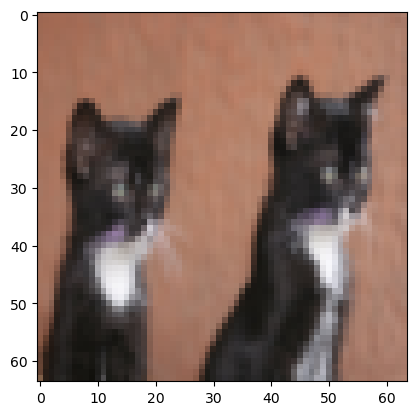

y = 1, you predicted that it is a cat picture.


In [40]:
# Example of a picture that was correctly classified.
imshow(testset_x[1,:,:,:]);
println("y = $(testset_y[1,2]), you predicted that it is a $(testset_class[d["Y_prediction_test"][1,2]+1]) picture.")

Just a short note - unlike python, Arrays in Julia is not 0-indexed, i.e. Arrays index begins not at 0, but at 1. And due to this, one needs to be mindful when mapping the label to the class, as it's no longer map to 0 and 1. This also explains the "+1" in "testset_class[d["Y_prediction_test"][1,2]+1]".

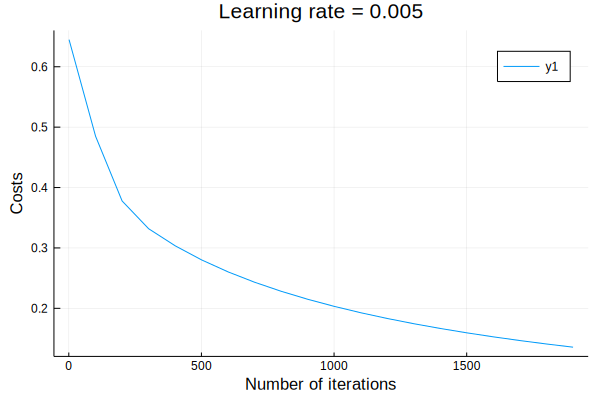

In [41]:
# Plot learning curve (with costs)
x = 1:100:2000
y = d["Cost"]
Plots.plot(x,y, title = "Learning rate = 0.005")
Plots.xlabel!("Number of iterations")
Plots.ylabel!("Costs")
